# EDA данных с новостного сайта РИА Новости

## Часть 1.2. Первичный анализ данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_pickle("df_ria.p", compression="gzip")
df.drop(columns="id", inplace=True)
df = df.reset_index(drop=True)

In [3]:
df.head()

url  \
0  https://ria.ru/20231101/zelenskiy-1906796283.html   
1  https://ria.ru/20231101/zelenskiy-1906778392.html   
2        https://ria.ru/20231101/deg-1906764127.html   
3  https://ria.ru/20231101/katastrofa-1906727435....   
4       https://ria.ru/20231101/nato-1906724588.html   

                                               title  \
0  СМИ: разочарованный Зеленский обрушился на Зап...   
1  СМИ: в команде Зеленского обрушились на него с...   
2  Минцифры заявило о готовности к проведению ДЭГ...   
3  Репрессии каждый день. Украине предрекли скору...   
4  По слабому месту. В Британии раскрыли, что Рос...   

                                            subtitle  \
0  NYT: Зеленского разочаровала недооценка Западо...   
1  Responsible Statecraft: команда Зеленского нач...   
2  Шадаев: Минцифры технически готово к проведени...   
3  Экс-советник Кучмы Соскин: на Украине будет гр...   
4  Sky: Россия обнажила слабые места бронетехники...   

                                             content          datetime  \
0  МОСКВА, 1 ноя — РИА Новости. Президент Украины...  19:51 01.11.2023   
1  МОСКВА, 1 ноя — РИА Новости. В команде Владими...  18:12 01.11.2023   
2  МОСКВА, 1 ноя - РИА Новости. Минцифры техничес...  17:37 01.11.2023   
3  МОСКВА, 1 ноя — РИА Новости. На Украине начнет...  16:03 01.11.2023   
4  МОСКВА, 1 ноя — РИА Новости. Российские вертол...  15:56 01.11.2023   

      topic  
0  politics  
1  politics  
2  politics  
3  politics  
4  politics

In [4]:
f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов"

'Размер датасета: 23190 строк, 6 столбцов'

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23190 entries, 0 to 23189
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       23190 non-null  object
 1   title     23190 non-null  object
 2   subtitle  23190 non-null  object
 3   content   23190 non-null  object
 4   datetime  23190 non-null  object
 5   topic     23190 non-null  object
dtypes: object(6)
memory usage: 1.1+ MB


Все данные имеют строковый формат. Для даты мы это исправим ниже. 

In [6]:
f"Количество дубликатов: {df.duplicated().sum()}"

'Количество дубликатов: 0'

Пустые строки не отображаются как nan значения, поэтому проверим отдельно, есть ли у нас в столбцах пустые строки.

In [7]:
df.content.apply(lambda x: len(x) == 0).sum()

1

In [8]:
df.title.apply(lambda x: len(x) == 0).sum()

0

In [9]:
df.subtitle.apply(lambda x: len(x) == 0).sum()

3684

In [10]:
df.datetime.apply(lambda x: len(x) == 0).sum()

0

Мы видим, что отсутствует основной текст в одной новости. И в 3684 строках нет второго заголовка. На этот признак опираться не будем, а 1 строку с пустым текстом удалим из нашего датафрейма.

In [11]:
df = df[~df.content.apply(lambda x: len(x) == 0)]

In [12]:
df.shape

(23189, 6)

### Распределение количества новостей по темам

In [13]:
print("\nThe size of each topic category\n")
pd.DataFrame(
    {"Topic": df.topic.value_counts().index, "Count": df.topic.value_counts().values}
)


The size of each topic category



Topic  Count
0    science   3942
1  incidents   3854
2    culture   3838
3   politics   3467
4      world   3319
5    economy   2389
6    society   2380

Немного проседают по количеству категории "society" и "economy" по сравнению с другими.  

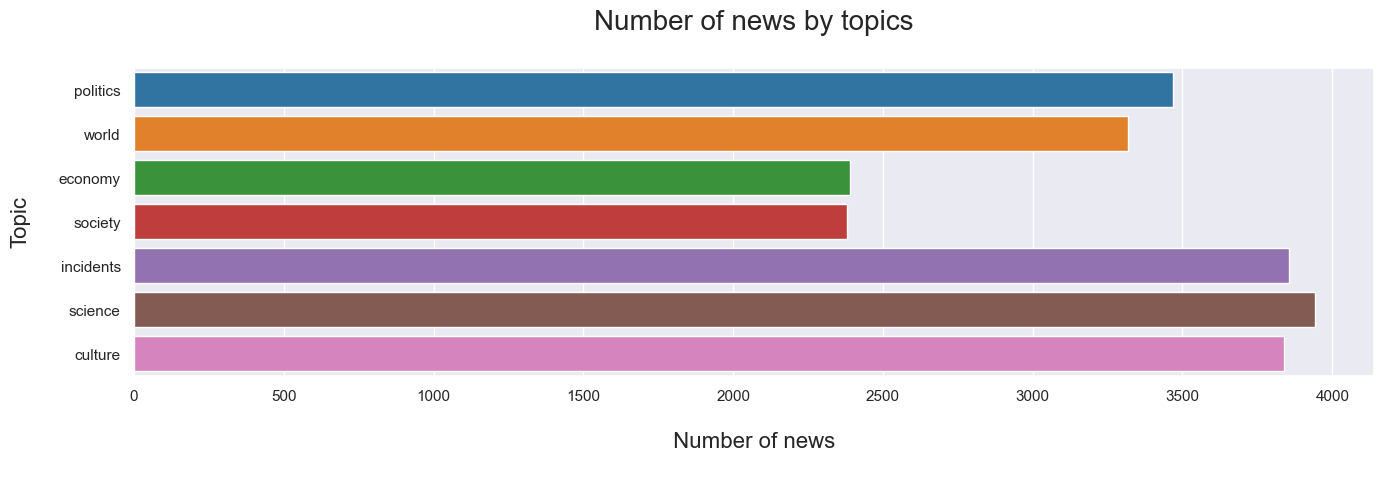

In [14]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(y=df["topic"], palette="tab10", ax=ax)
plt.xlabel("\n Number of news \n", fontsize=16)
plt.ylabel("Topic\n", fontsize=16)
plt.title("Number of news by topics\n", fontsize=20)
plt.show();

#### Вывод 

* Больше всего новостей в данном датасете на тему "наука". 

* Далее по количеству новостей идут категории "происшествия" и "культура". 

* Меньше всего новостей - на тему "общества". 

* Возможно, следует добавить статей по категории economy и society для сбалансированности данных.

### Распределения количества новостей по времени выпуска

In [15]:
df.datetime

0        19:51 01.11.2023
1        18:12 01.11.2023
2        17:37 01.11.2023
3        16:03 01.11.2023
4        15:56 01.11.2023
               ...       
23185    08:00 15.08.2022
23186    01:17 15.08.2022
23187    17:17 14.08.2022
23188    15:38 14.08.2022
23189    12:42 14.08.2022
Name: datetime, Length: 23189, dtype: object

Дата имеет строковый тип данных, преобразуем значения столбца в тип данных datetime и извлечем новые признаки: год выпуска статьи, месяц, день недели.  

In [16]:
df["datetime"] = pd.to_datetime(df["datetime"], format="%H:%M %d.%m.%Y")
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["weekday"] = df["datetime"].dt.day_name()

In [17]:
df.weekday.value_counts()

weekday
Tuesday      4045
Wednesday    3975
Monday       3954
Thursday     3859
Friday       3522
Saturday     2000
Sunday       1834
Name: count, dtype: int64

In [18]:
df.datetime.describe()

count                            23189
mean     2023-05-22 10:26:43.419725056
min                2021-04-13 09:00:00
25%                2023-03-29 15:33:00
50%                2023-09-11 06:48:00
75%                2023-10-18 05:26:00
max                2023-11-01 22:00:00
Name: datetime, dtype: object

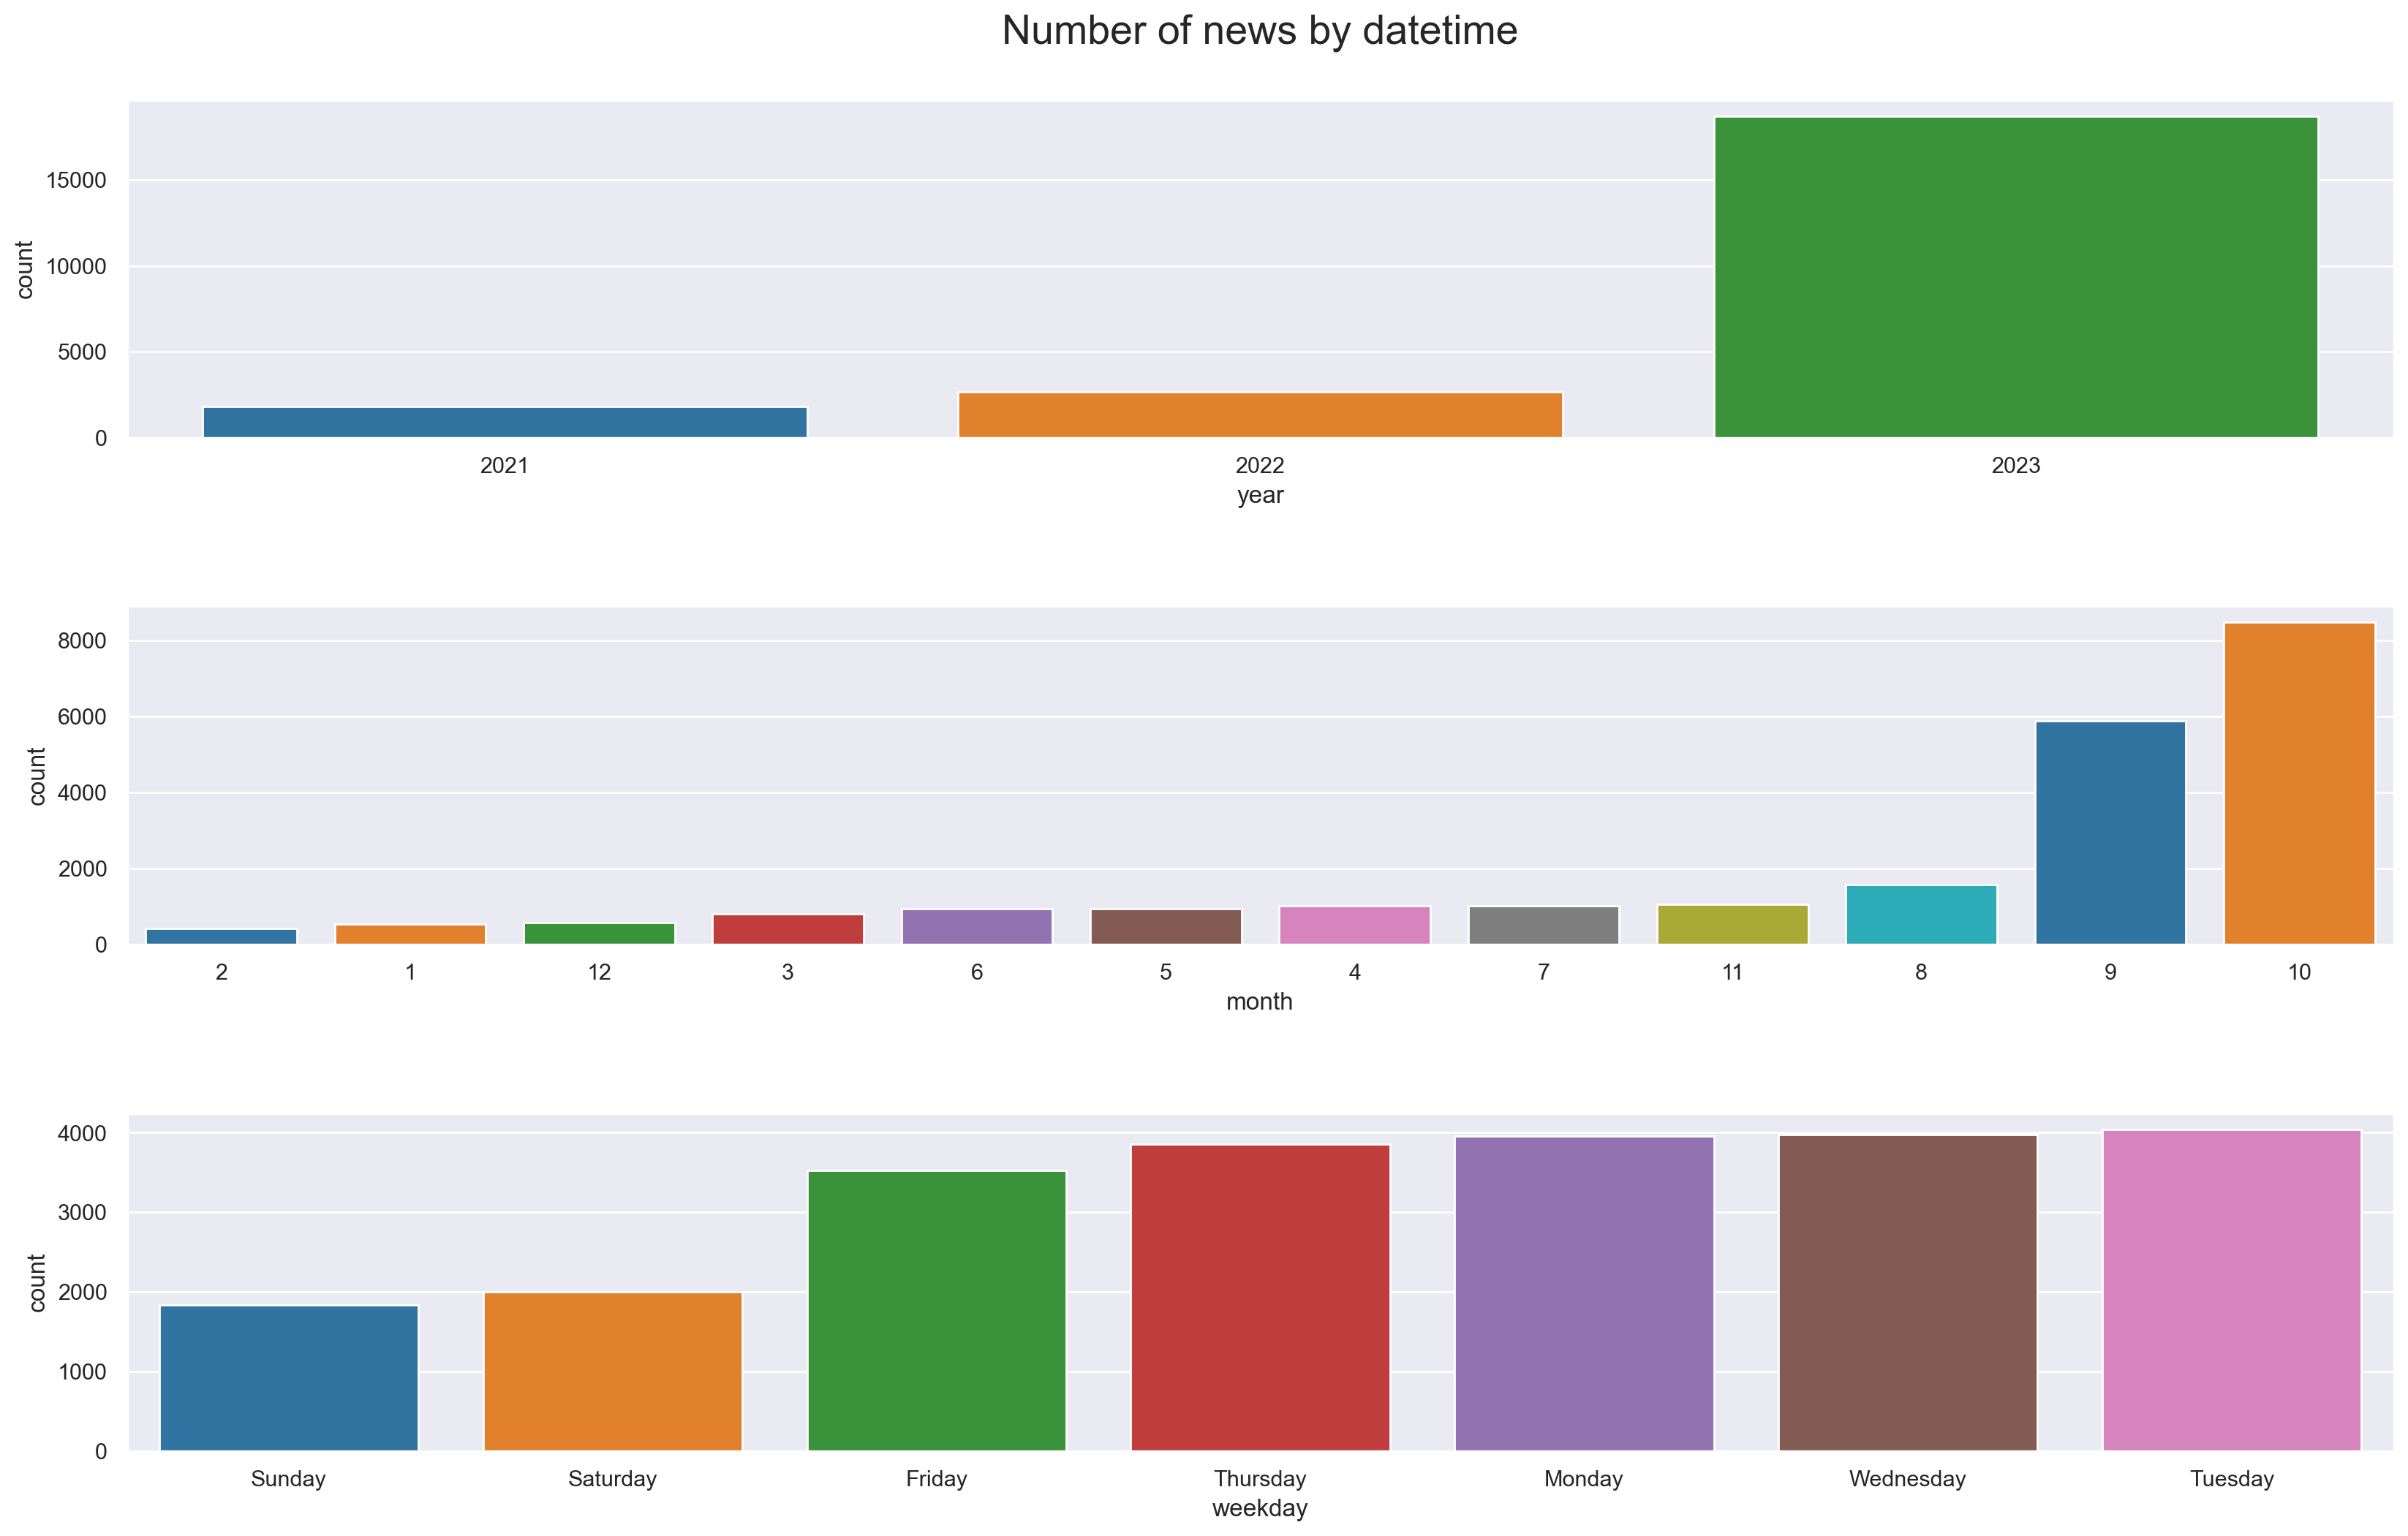

In [19]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month", "weekday"]):
    sns.countplot(
        x=df[col],
        palette="tab10",
        ax=axs[ind],
        order=df[col].value_counts(ascending=True).index,
    )
axs[0].set_title("Number of news by datetime\n", fontsize=20)
plt.subplots_adjust(hspace=0.5);

#### Вывод:

* Датасет включает в себя новости, выпущенные в период с 4 апреля 2021 года по 1 ноября 2023 года.

* Больше всего новостей относятся к 2023 году.

* На сентябрь и ноябрь приходится большая часть новостей. 

* Меньше всего новостей в выходные и больше всего в начале недели.

### Текстовые статистики

Парсинг был сделан грубовато в основном тексте статьи, поэтому уберем лишние сниппеты заголовков других статей с помощью регулярного выражения, а также избавимся от указания локации, источника и автора статьи в самом начале и от подписей фото по возможности.

In [20]:
def clean_text(text):

    # убираем вставки с заголовками других статей, узко, чтобы не тронуть лишнего
    text = re.sub(r"\.(?!\.)[^.]{3,}\n\n\nПоделиться\n\n", ". ", text)
    text = re.sub(r"\n+", " ", text)  # убираем перенос строки = заменяем на пробел
    # МОСКВА, 1 ноя — РИА Новости, Михаил Катков.
    text = re.sub(r"^[А-ЯЁ].{2,}\W{2}РИА Новости, [\w\s,]+\.", "", text)  # —-–
    # КАЛИНИНГРАД, 22 авг — РИА Новости. Картины...
    text = re.sub(r"^[А-ЯЁ].{2,}\W{2}РИА Новости\.", "", text)
    # подписи к фото
    text = re.sub(r"©.+медиабанк", " ", text)
    text = re.sub(r"©.+Photo.+[a-z]", " ", text)  # 122
    # Когда склеен пунктуатор и последующее слово: "говорится в статье.По мнению", чтобы потом правильно токенизировать
    text = re.sub(r"([.,:!?\)])(?=[а-яёa-z№А-ЯЁA-Z])", r"\1 ", text)

    return text.strip()

In [21]:
df.loc[23108]["content"][:100]

'КАЛИНИНГРАД, 22 авг — РИА Новости. Картины про непредсказуемые выходные, полет в космос и рыбалку ст'

In [22]:
df.loc[12].content[:100]

'МОСКВА, 1 ноя — РИА Новости, Михаил Катков. Попытки Киева присоединить к антироссийской коалиции стр'

In [23]:
df.loc[17283].content[3000:]

'е экспортировать весь архив, письма без вложений весят совсем немного. Наконец, в мессенджере WhatsApp (детище все той же Meta, то есть бывшего Facebook) есть возможность сохранить всю историю и переписку аккаунта.   в виде не только бэкапа, но и готового чата для Telegram — достаточно в настройках выбрать опцию "Экспорт чата" и во вкладке "Поделиться" отметить Telegram.Эксперт посоветовал вывести данные из хранилища Google и iCloud10 марта 2022, 14:17\n\n\nПоделиться\n\nХорошо забытое староеДля полной уверенности, что документы, фото и видео точно останутся под рукой и безо всяких ограничений, стоит задуматься о локальном оффлайн-хранилище. "Облака" — это, конечно, хорошо, но не так надежно, как хотелось бы.\n\n\n\n\n\n\n \n\n\nОпределитесь с объемом и бюджетом. Внешний жесткий диск формата 3,5 дюйма объемом четыре терабайта подорожал вдвое — до 15-18 тысячи рублей.Можно и вовсе замахнуться на сетевое хранилище NAS — мини-сервер, подключенный к сети из накопителей. Это обеспечит бесп

In [24]:
df.loc[22532].content

'МОСКВА, 14 окт — РИА Новости. В сирийском городе Эр-Растан в провинции Хомс нашли большую неповрежденную древнеримскую мозаику, сообщает Associated Press. Ее  назвали самым важным археологическим открытием с начала военного конфликта в стране 11 лет назад.Площадь произведения — 120 квадратных метров. © AP Photo / Omar SanadikiМозаика времен римской эпохи в городе Эр-Растан, Сирия© AP Photo / Omar SanadikiМозаика времен римской эпохи в городе Эр-Растан, СирияСреди представленных сцен — редкое изображение амазонок из римской мифологии и Троянской войны. Еще на мозаике есть образ Нептуна, древнеримского бога моря, и его 40 любовниц. \n\n\n\n\n\n\n\n\n\n\n\nРисунок был обнаружен в одной из древних построек. Раскопки еще идут, и ученые пока не могут определить тип этого здания. Пока неясно, была ли там общественная баня или что-то еще. В Египте обнаружили саркофаг казначея фараона Рамзеса II6 октября 2022, 18:44\n\n\nПоделиться\n\n'

In [25]:
%%time
df["content"] = df["content"].apply(clean_text)

Wall time: 5.34 s


In [26]:
df.loc[23108]["content"][:100]

'Картины про непредсказуемые выходные, полет в космос и рыбалку стали лауреатами X фестиваля коротком'

In [27]:
df.loc[12].content[:100]

'Попытки Киева присоединить к антироссийской коалиции страны Глобального Юга провалились. При этом, к'

In [28]:
df.loc[17283].content

'Привычные международные онлайн-сервисы и облачные хранилища теперь ненадежны для российских пользователей: угроза лишиться важных данных вполне реальна. Что делать и как сохранить персональный цифровой "багаж" — в материале РИА Новости. Бережем контентЗаблокированный в России Instagram унес с собой визуальный контент, копившийся более десяти лет. Правда, Роскомнадзор дал пару дней на перенос. С 14 марта приложение и веб-версия соцсети не открываются. Впрочем, и сейчас забрать данные можно — с помощью VPN, для этого даже есть встроенные инструменты. Причем речь не только о фото и сториз, но и о комментариях. В настройках аккаунта нужно найти строчку "Ваша активность" и пункт "Скачать информацию". Ввести почту и пароль учетной записи и ждать, когда придет ссылка на архив — в зависимость от объема на это требуется от часа до двух суток. Участь этой соцсети может разделить и популярный видеохостинг YouTube — Роскомнадзор неоднократно выносил предупреждения американской компании. Есть множ

In [29]:
df.loc[22532].content

'В сирийском городе Эр-Растан в провинции Хомс нашли большую неповрежденную древнеримскую мозаику, сообщает Associated Press. Ее  назвали самым важным археологическим открытием с начала военного конфликта в стране 11 лет назад. Площадь произведения — 120 квадратных метров.  Мозаика времен римской эпохи в городе Эр-Растан, СирияСреди представленных сцен — редкое изображение амазонок из римской мифологии и Троянской войны. Еще на мозаике есть образ Нептуна, древнеримского бога моря, и его 40 любовниц.  Рисунок был обнаружен в одной из древних построек. Раскопки еще идут, и ученые пока не могут определить тип этого здания. Пока неясно, была ли там общественная баня или что-то еще.'

In [30]:
df.loc[6].content

'Госдума проголосовала за проекты постановлений о досрочном прекращении полномочий депутатов Вадима Белоусова и Василия Власова, сообщила пресс-служба Думы. Обсуждение проводилось в закрытом режиме. Депутаты проголосовали за прекращение полномочий парламентариев. Комиссия Госдумы по этике во вторник рассмотрела материалы от комитета по защите конкуренции и комиссии по регламенту и обеспечению деятельности Государственной думы о систематическом отсутствии на своих заседаниях депутатов Вадима Белоусова и Василия Власова и сочла достаточными основания для досрочного прекращения их полномочий. Она также приняла решение о представлении материалов по ним в комиссию по мандатным вопросам, в палату внесли проекты постановлений о лишении их полномочий. Ранее Конституционный суд не принял к рассмотрению жалобу, поданную адвокатами от имени депутата Госдумы Вадима Белоусова, приговоренного к десяти годам колонии за получение взятки в три миллиарда рублей и усомнившегося в конституционности законо

#### Посимвольные длины заголовков и основного текста

Посчитаем посимвольную длину заголовков и основного текста. 

In [31]:
df["len_title"] = df["title"].str.len()
df["len_subtitle"] = df["subtitle"].str.len()
df["len_content"] = df["content"].str.len()

In [32]:
df.groupby("topic")["len_title"].describe()

count       mean        std   min   25%   50%   75%   max
topic                                                                
culture    3838.0  59.648515  11.808798  14.0  52.0  62.0  69.0  75.0
economy    2389.0  63.825031   9.629590  25.0  58.0  66.0  72.0  75.0
incidents  3854.0  61.033991  10.515058  28.0  54.0  63.0  70.0  75.0
politics   3467.0  62.462359  10.729586  16.0  56.0  65.0  71.0  75.0
science    3942.0  61.387874   9.854176  27.0  55.0  63.0  69.0  88.0
society    2380.0  62.995798  10.060932  19.0  57.0  66.0  71.0  75.0
world      3319.0  64.371497   9.368887  16.0  59.0  67.0  72.0  75.0

In [33]:
df.groupby("topic")["len_subtitle"].describe()

count       mean        std  min   25%   50%   75%    max
topic                                                                
culture    3838.0  70.576863  24.747433  0.0  69.0  79.0  85.0   90.0
economy    2389.0  64.815823  24.567251  0.0  67.0  75.0  78.0   80.0
incidents  3854.0  72.952517   7.793172  0.0  70.0  75.0  78.0   80.0
politics   3467.0  73.160946  20.094412  0.0  72.0  78.0  84.0   90.0
science    3942.0  31.806443  39.930310  0.0   0.0   0.0  79.0  101.0
society    2380.0  60.926891  28.145655  0.0  63.0  74.0  78.0   80.0
world      3319.0  73.058753  10.066170  0.0  71.0  76.0  78.0   80.0

In [34]:
df.groupby("topic")["len_content"].describe()

count         mean          std    min      25%     50%      75%  \
topic                                                                          
culture    3838.0  1538.887962  1619.892890   80.0   793.00  1104.5  1639.75   
economy    2389.0  1640.243617  1363.258229   60.0   938.00  1385.0  1942.00   
incidents  3854.0  1123.106124   684.616114   98.0   704.25   977.0  1354.75   
politics   3467.0  1249.605423  1052.687808   66.0   700.00  1037.0  1498.00   
science    3942.0  2804.686454  2310.537500   83.0  1095.00  2158.0  3405.75   
society    2380.0  1663.454202  1439.152926   98.0   867.00  1289.0  1895.00   
world      3319.0  1920.316662  1048.343142  151.0  1067.00  1789.0  2579.50   

               max  
topic               
culture    28358.0  
economy    21127.0  
incidents   9317.0  
politics   21231.0  
science    18083.0  
society    16529.0  
world      13616.0

Посмотрим, как они выглядят в разрезе каждой категории.

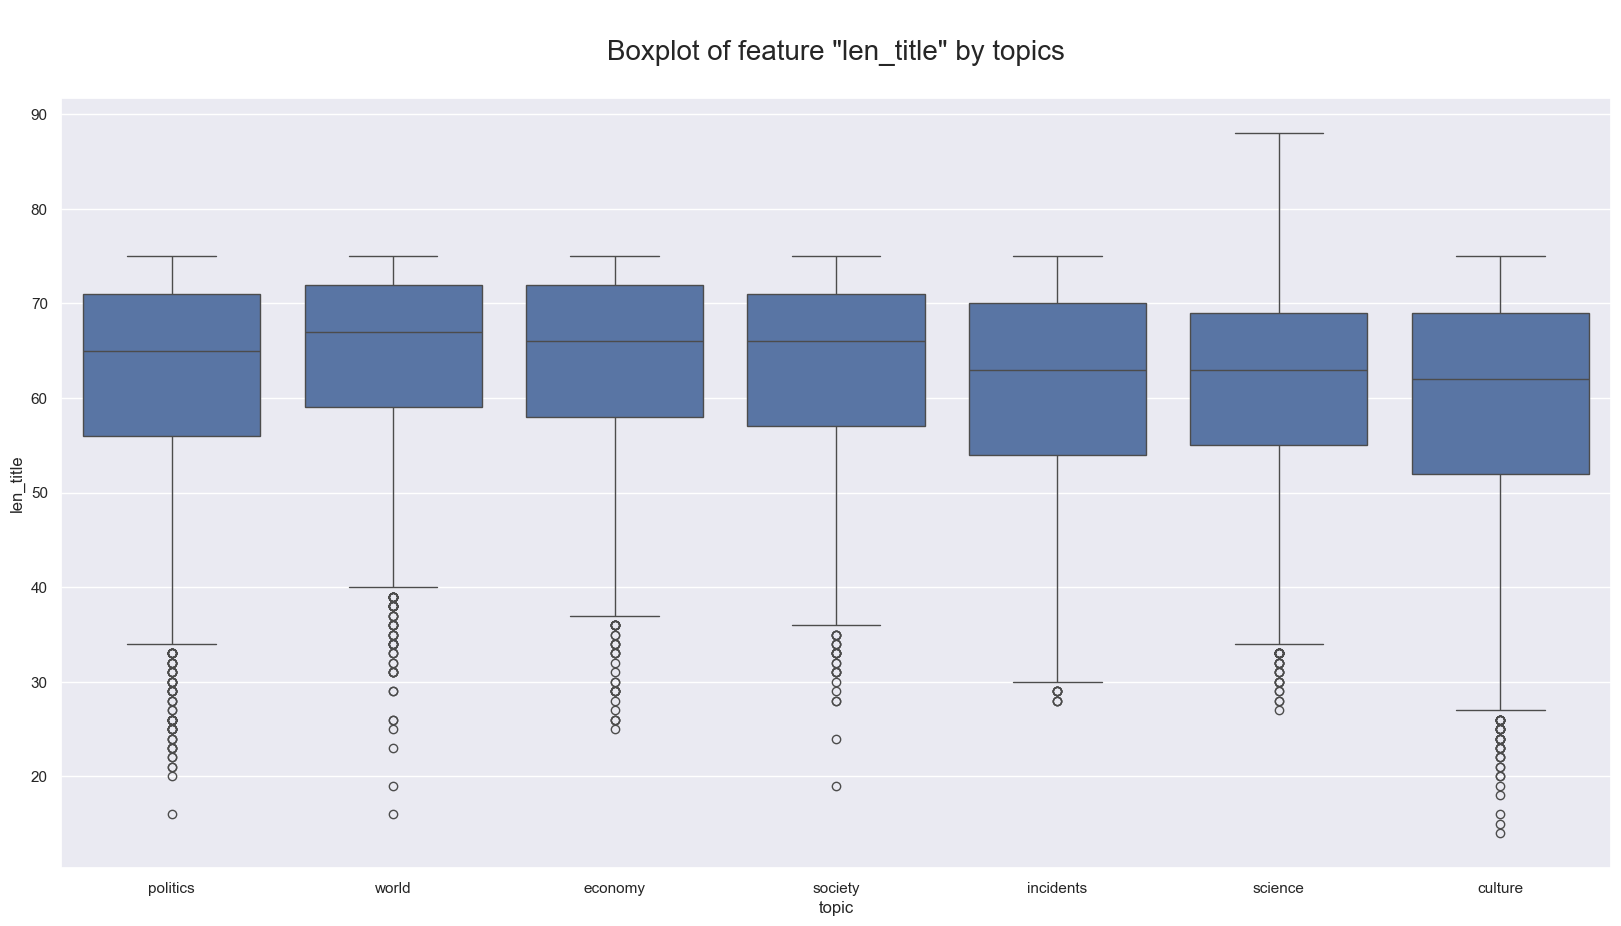

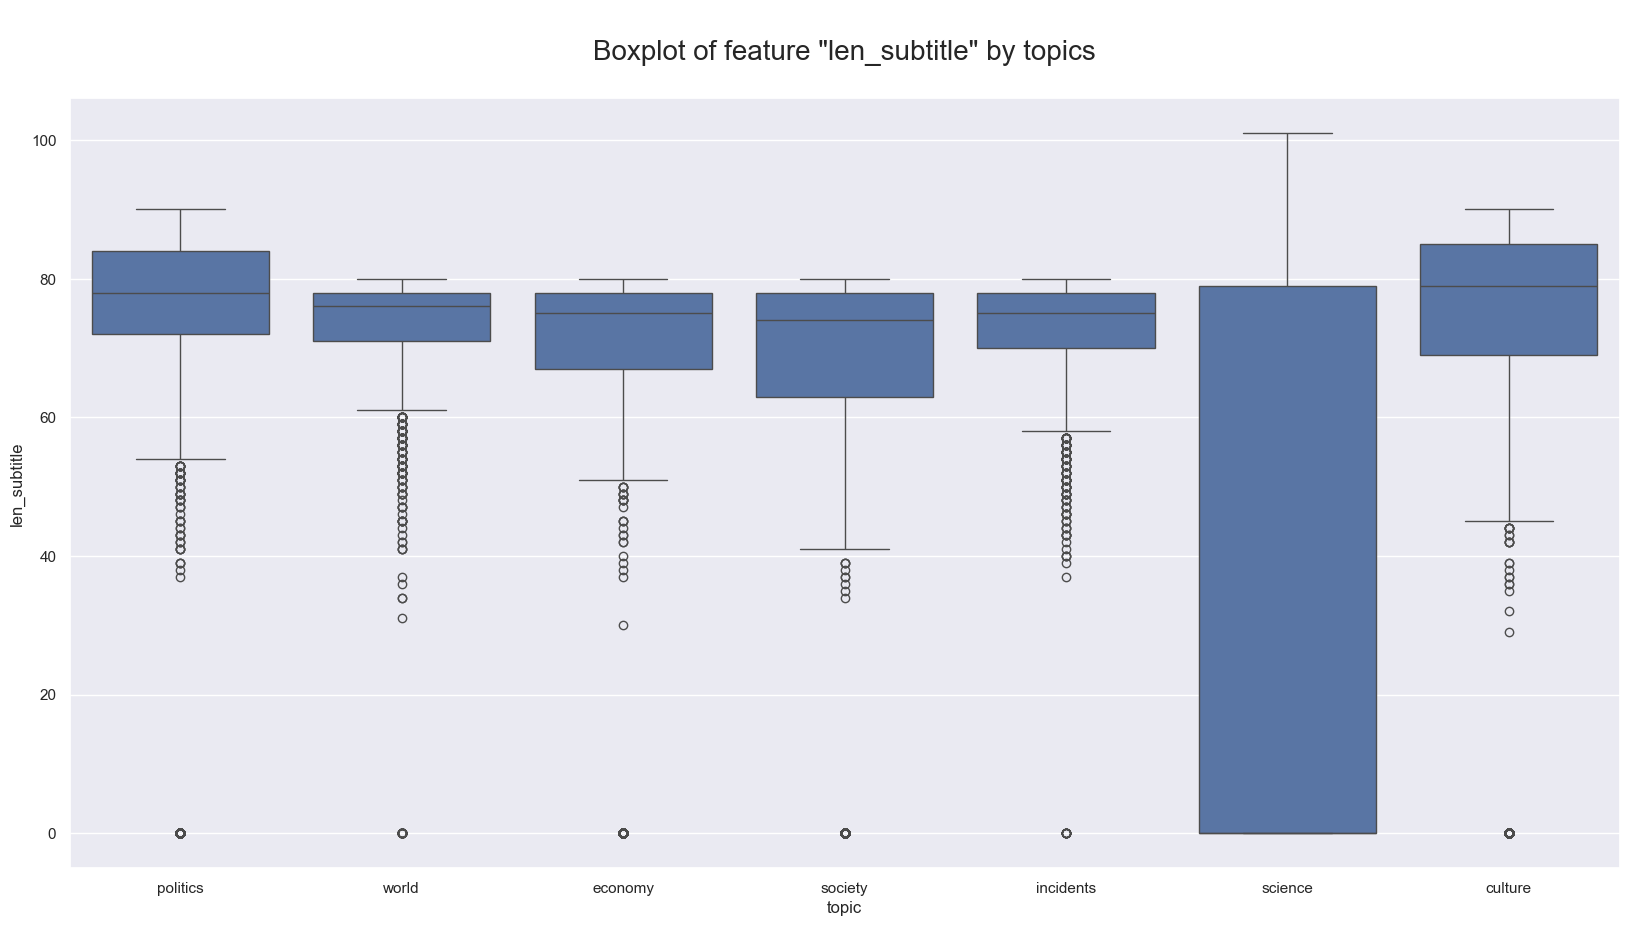

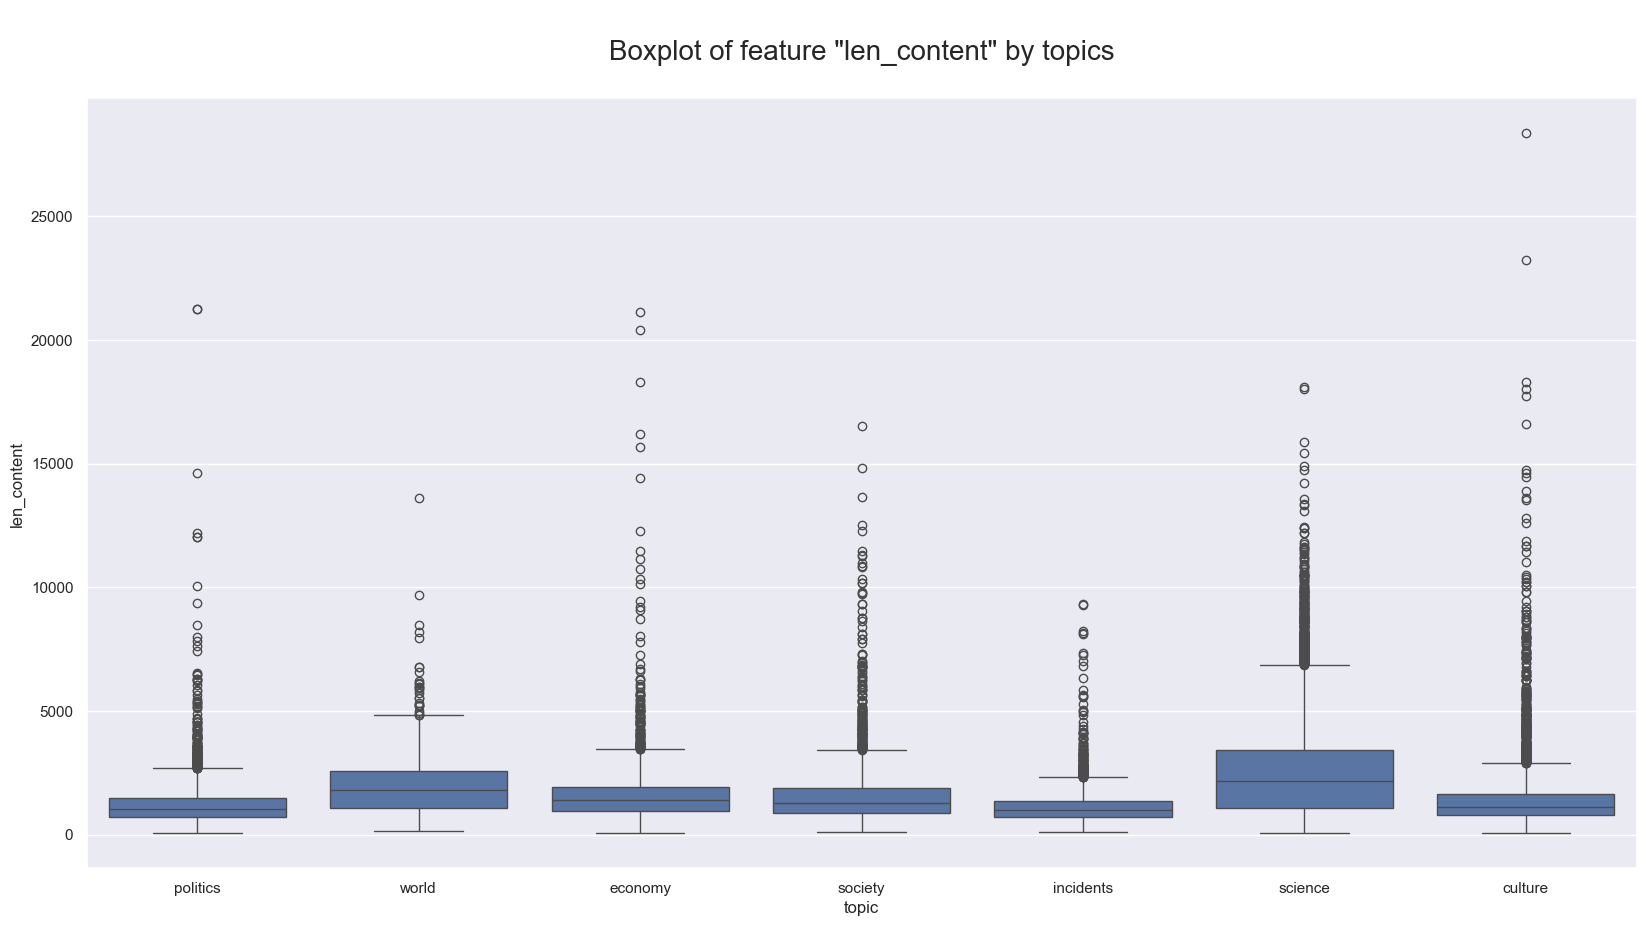

In [35]:
for col in ["len_title", "len_subtitle", "len_content"]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'\nBoxplot of feature "{col}" by topics\n', fontsize=20)

Отдельно посмотрим на распределения характеристик длин - распределения  не являются нормальными. Значит, перед обучением модели нужно будет логарифмировать эти признаки.

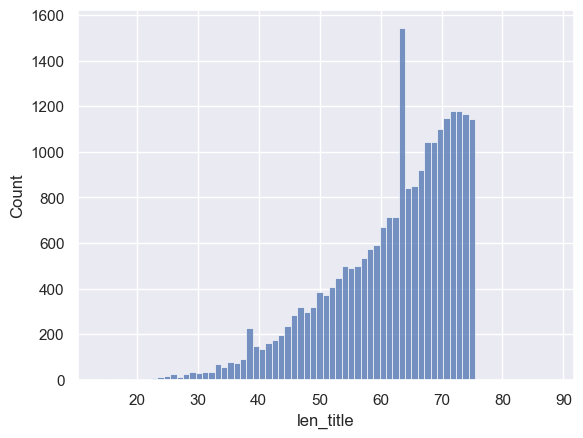

In [36]:
sns.histplot(df.len_title);

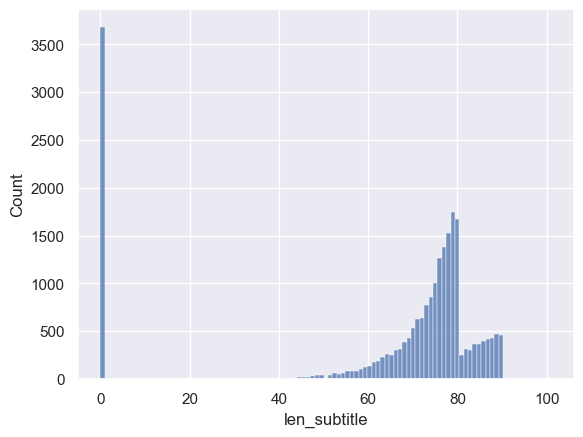

In [37]:
sns.histplot(df.len_subtitle);

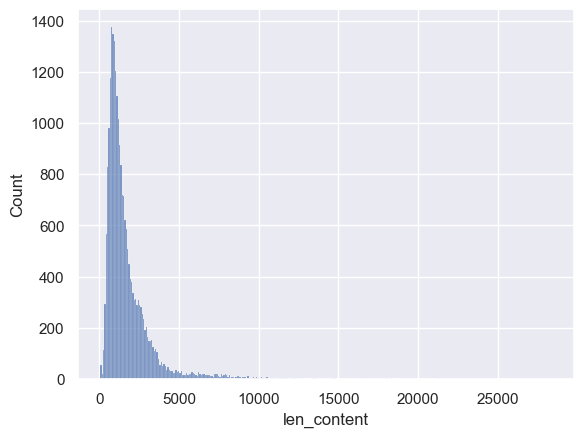

In [38]:
sns.histplot(df.len_content);

##### Вывод:

* В среднем длина заголовка по всем категориям около 65 символов.

* Второй загловок по некоторым статьям недоступен, поэтому в будущем этот признак следует отбросить. 

- Длина текста имеет тяжелые хвосты, особенно по категориям: 'culture', 'society', 'economy'. Наиболее короткие новости относятся к теме incidents. 

* Признаки длин не имеют лог нормальное распределение. 

#### Вычисление словаря корпуса

С помощью токенизатора NLTK разобьем текст на токены.

In [39]:
%%time
tokens = df.content.apply(word_tokenize)

Wall time: 1min 2s


In [40]:
def flatten(tokenized_texts):
    return [word for text in tokenized_texts for word in text]

In [41]:
all_tokens = pd.Series(flatten(tokens))

In [42]:
len(all_tokens)

6371270

In [43]:
all_tokens[:5]

0        Президент
1          Украины
2         Владимир
3        Зеленский
4    раскритиковал
dtype: object

Отфильтруем токены - оставим только буквенные и цифры, но предварительно сохраним токены с дефисом. 
А также исключим стоп-слова и приведем все токены к нижнему регистру.

In [44]:
tokens_with_hyphen = []
for token in all_tokens:
    if re.findall(r"[а-яA-Z]-[а-яA-Z]", token):
        tokens_with_hyphen.append(token)

In [45]:
tokens_with_hyphen[:5]

['из-за', 'из-за', 'наконец-то', 'где-то', 'из-за']

In [46]:
len(tokens_with_hyphen)

42299

In [47]:
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "риа",
        "новости",
        "фото",
        "предоставлено",
    ]
)

In [48]:
%%time
tokens_filtered = [
    token.lower() for token in all_tokens if token.isalnum()
] + tokens_with_hyphen
tokens_filtered = [token for token in all_tokens if token not in stop_words]

Wall time: 19.5 s


In [49]:
f"Размер нелематизированного корпуса без стоп-слов {len(tokens_filtered)} токенов"

'Размер нелематизированного корпуса без стоп-слов 5160912 токенов'

In [50]:
tokens_filtered[:10]

['Президент',
 'Украины',
 'Владимир',
 'Зеленский',
 'раскритиковал',
 'Запад',
 'нереалистичных',
 'ожиданий',
 'ВСУ',
 'поле']

#### Ключевые слова тематик

Посмотрим, какие ключевые слова чаще всего встречаются в заголовках статей каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

Wall time: 34 s


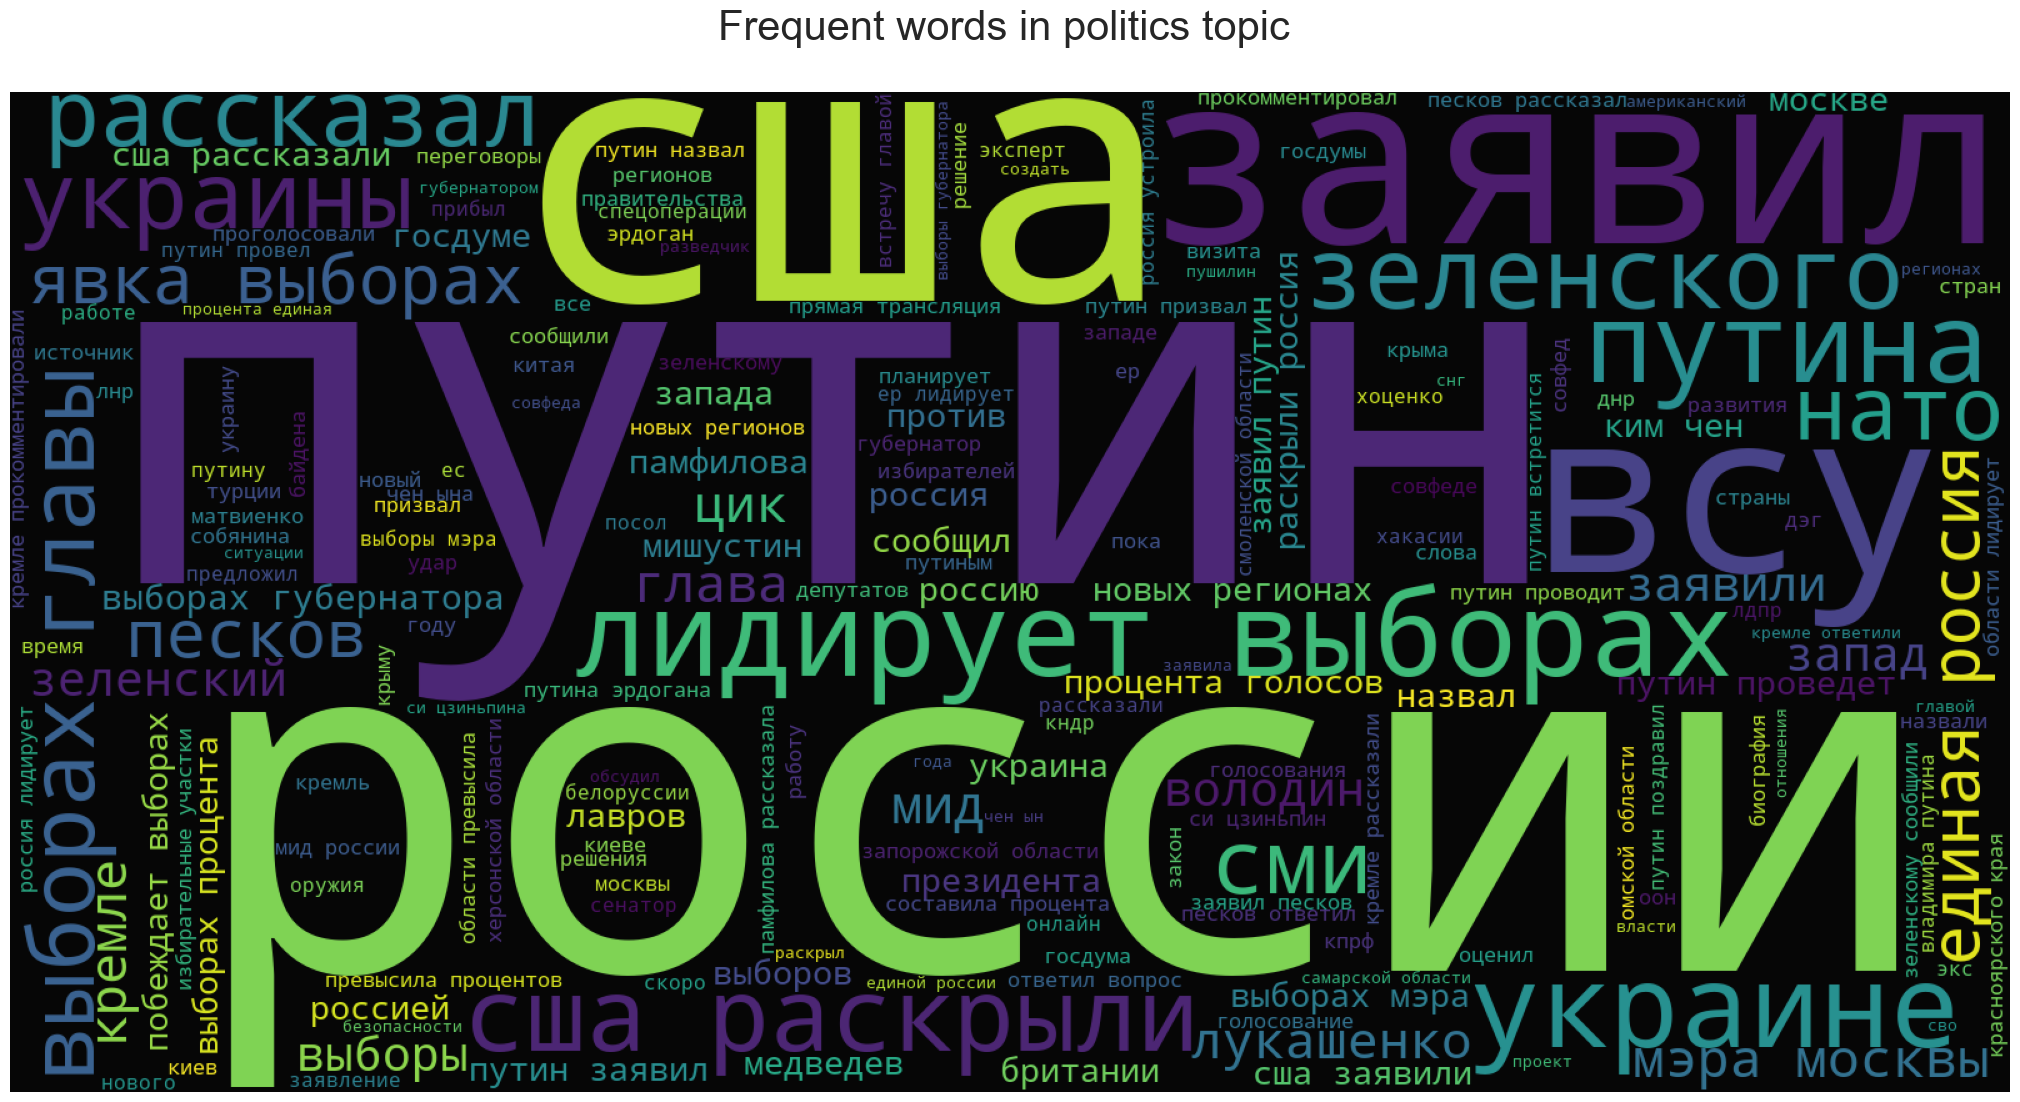

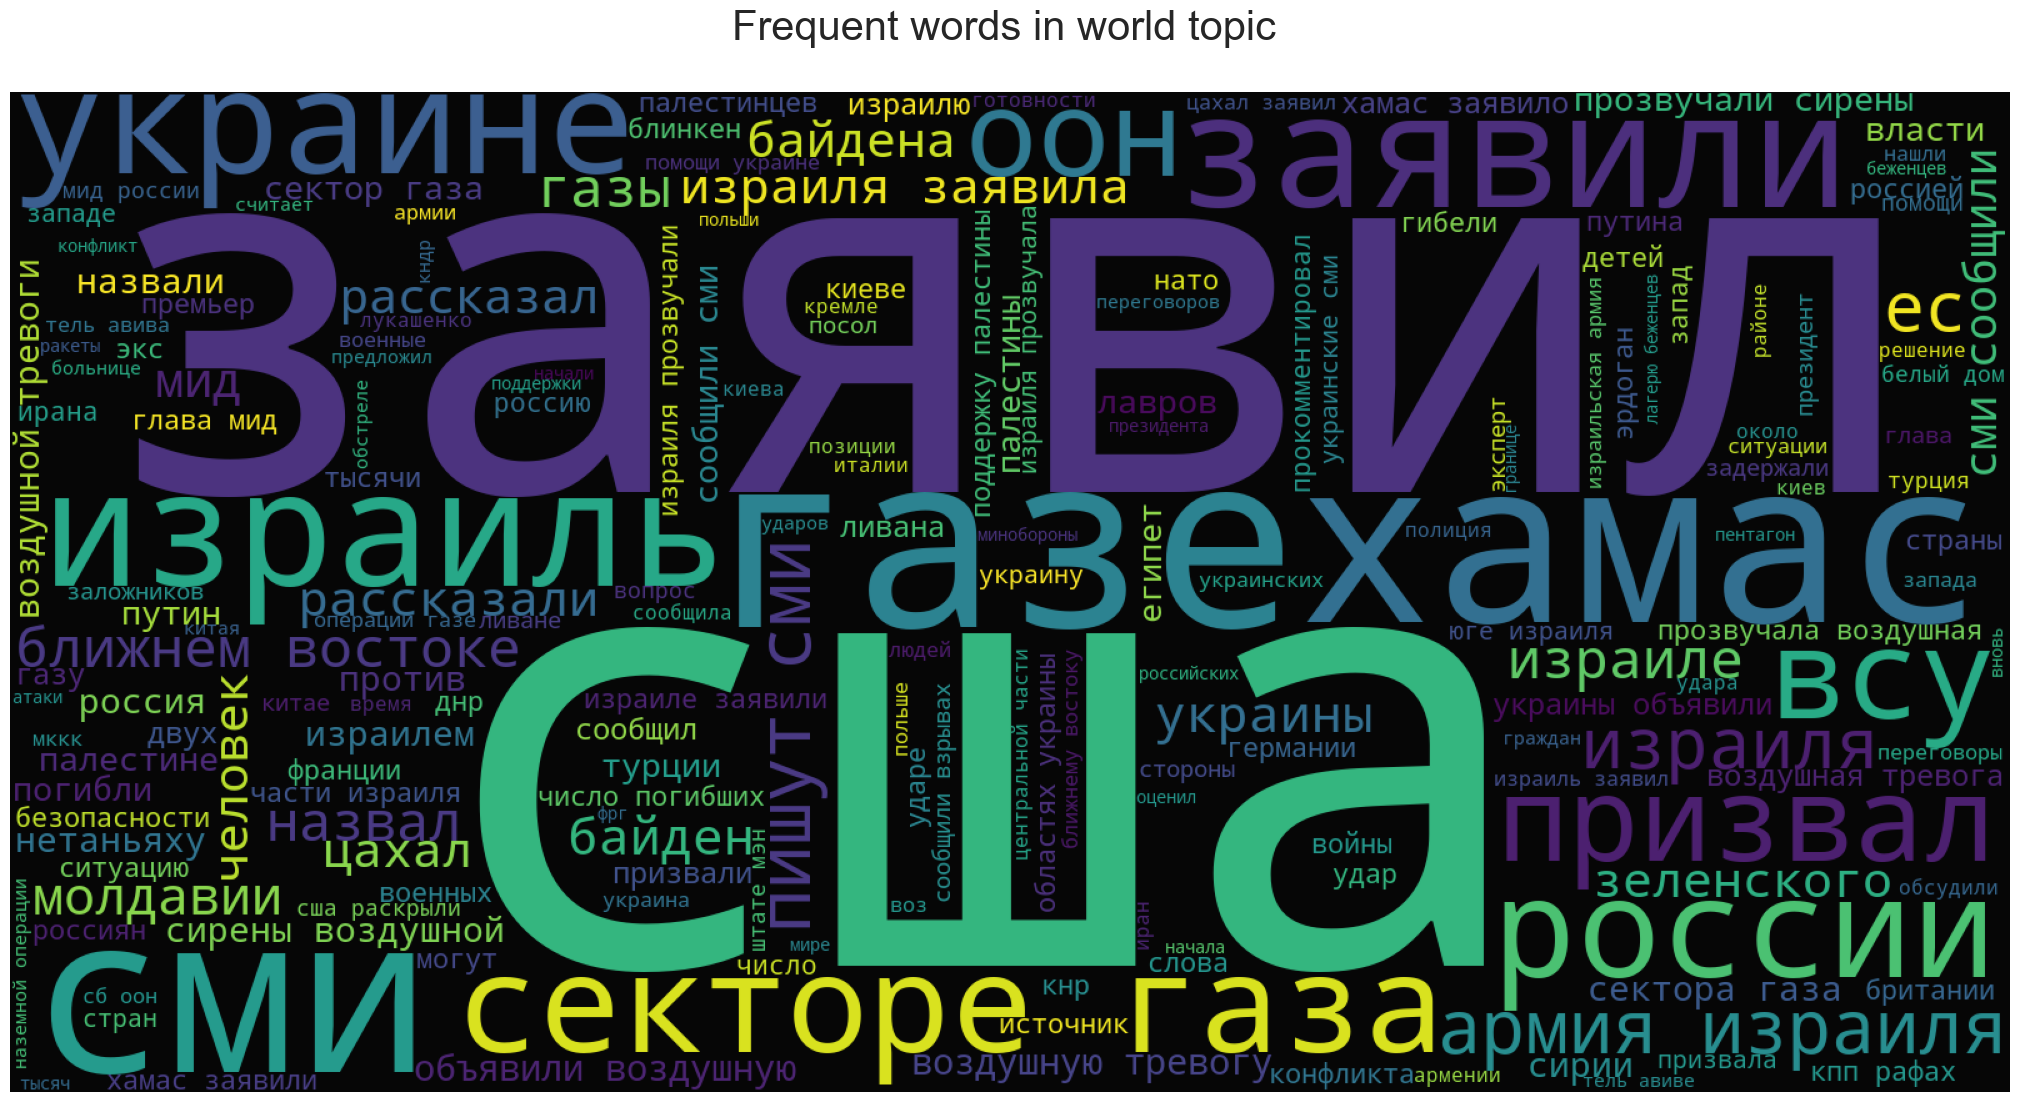

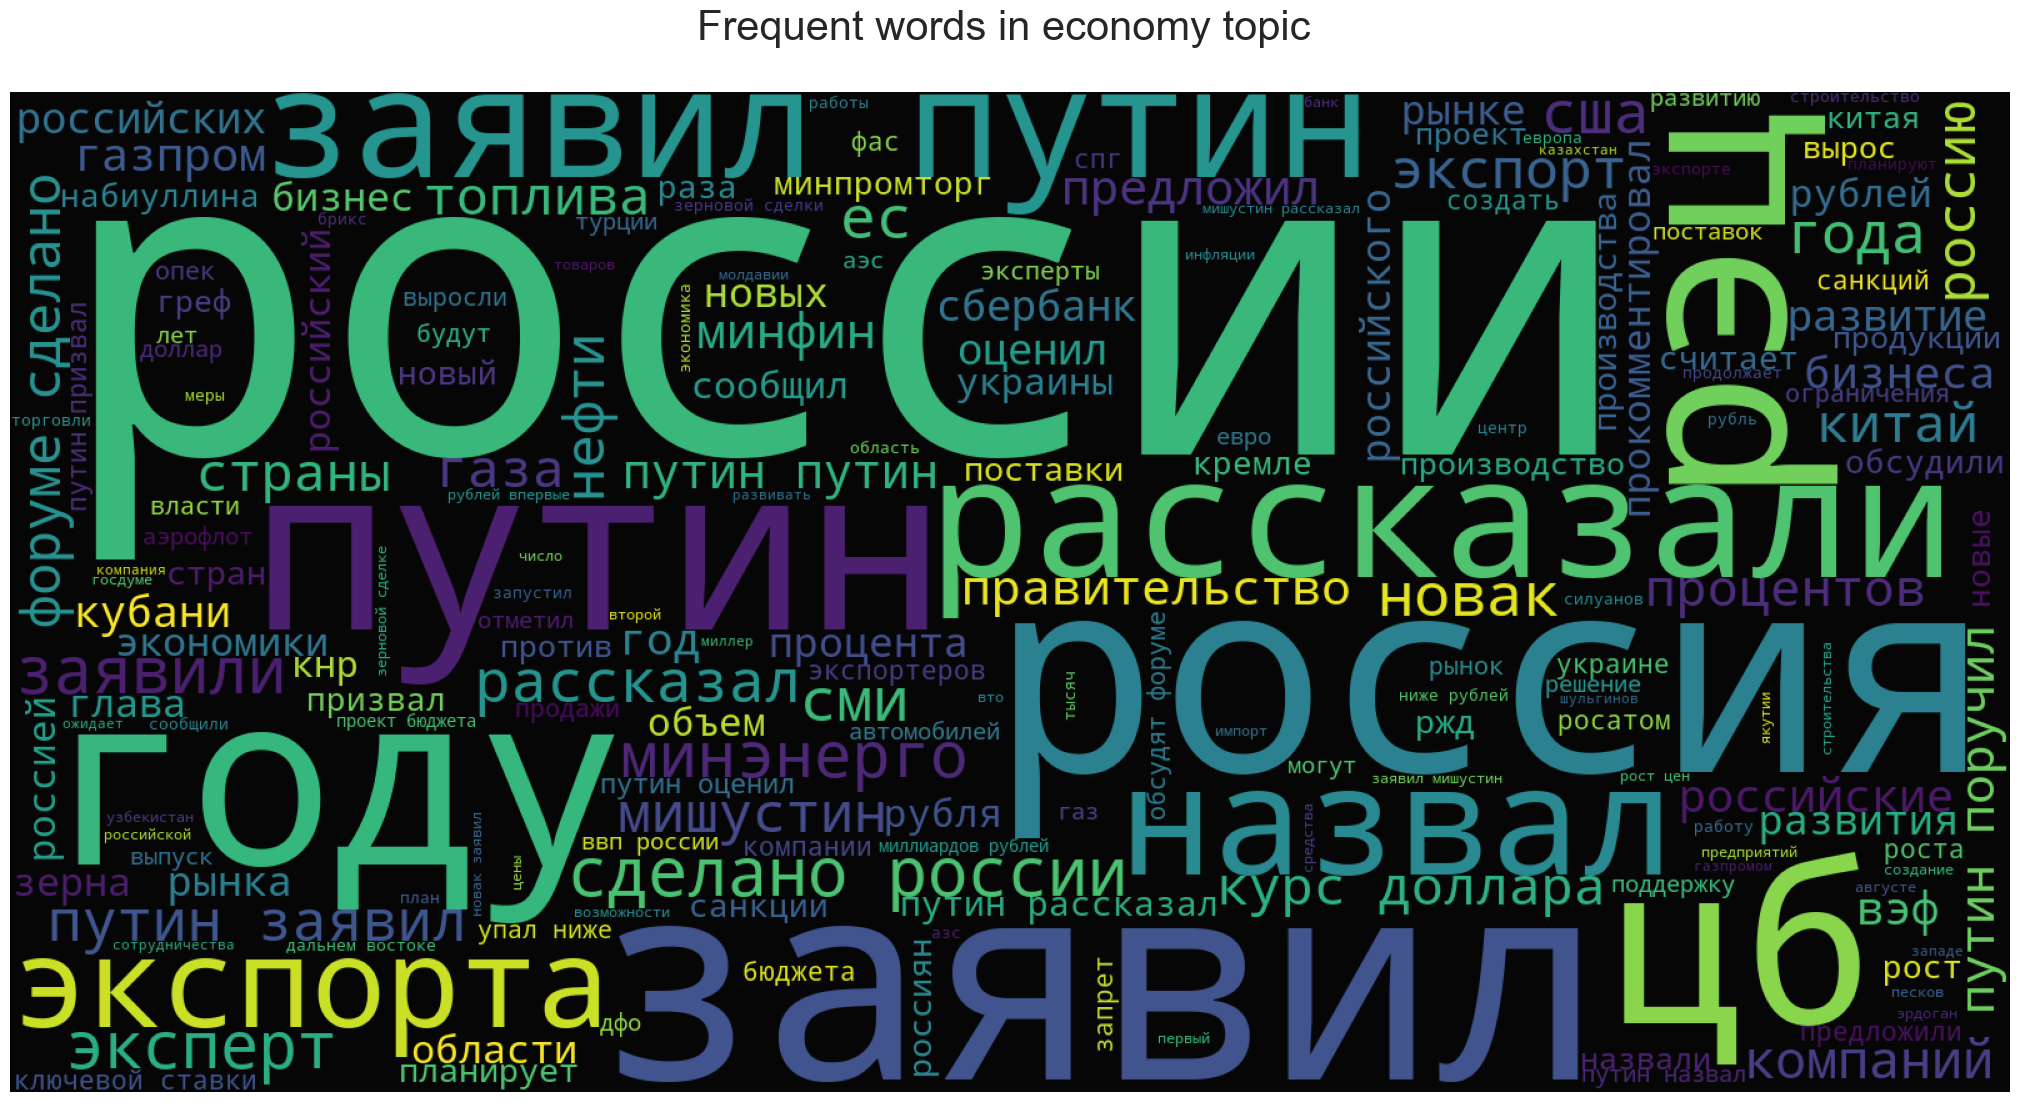

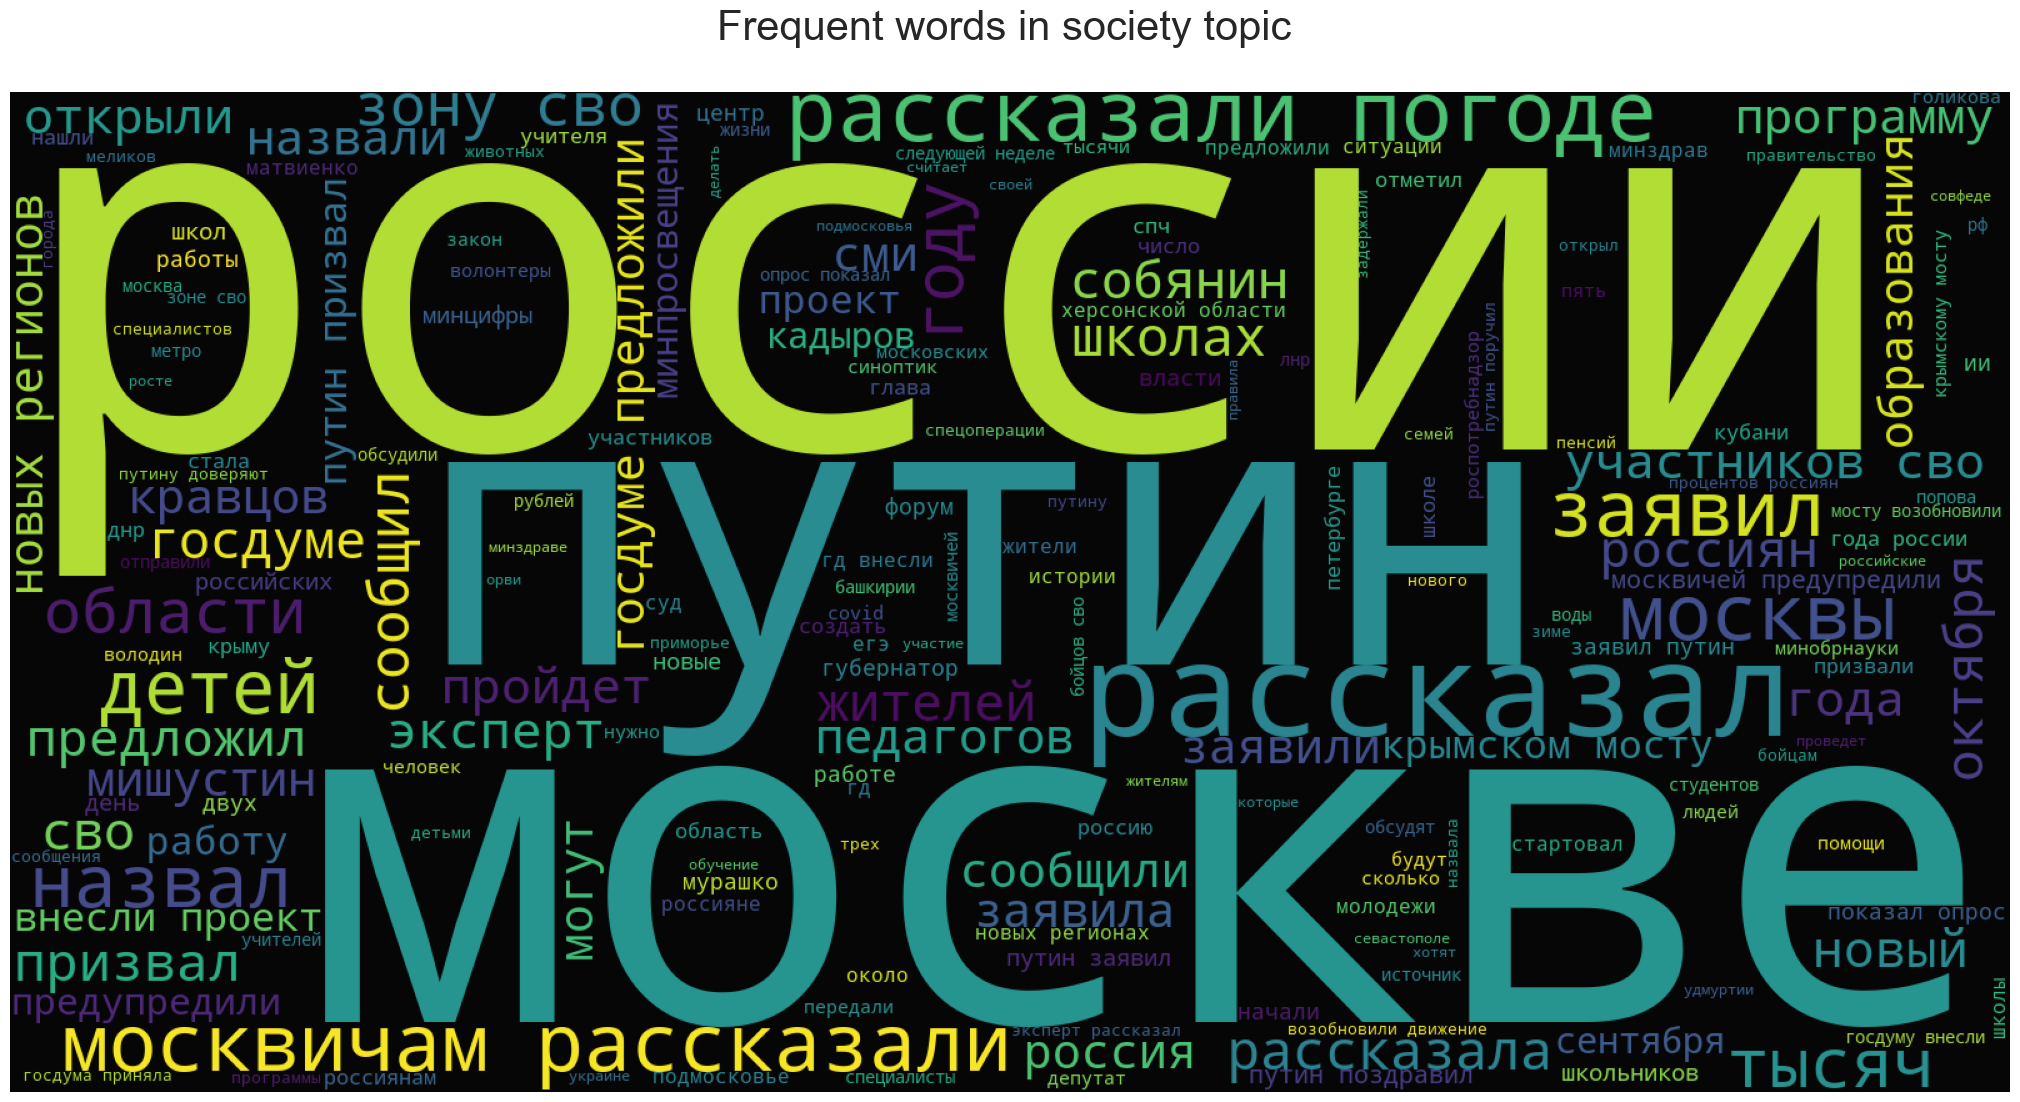

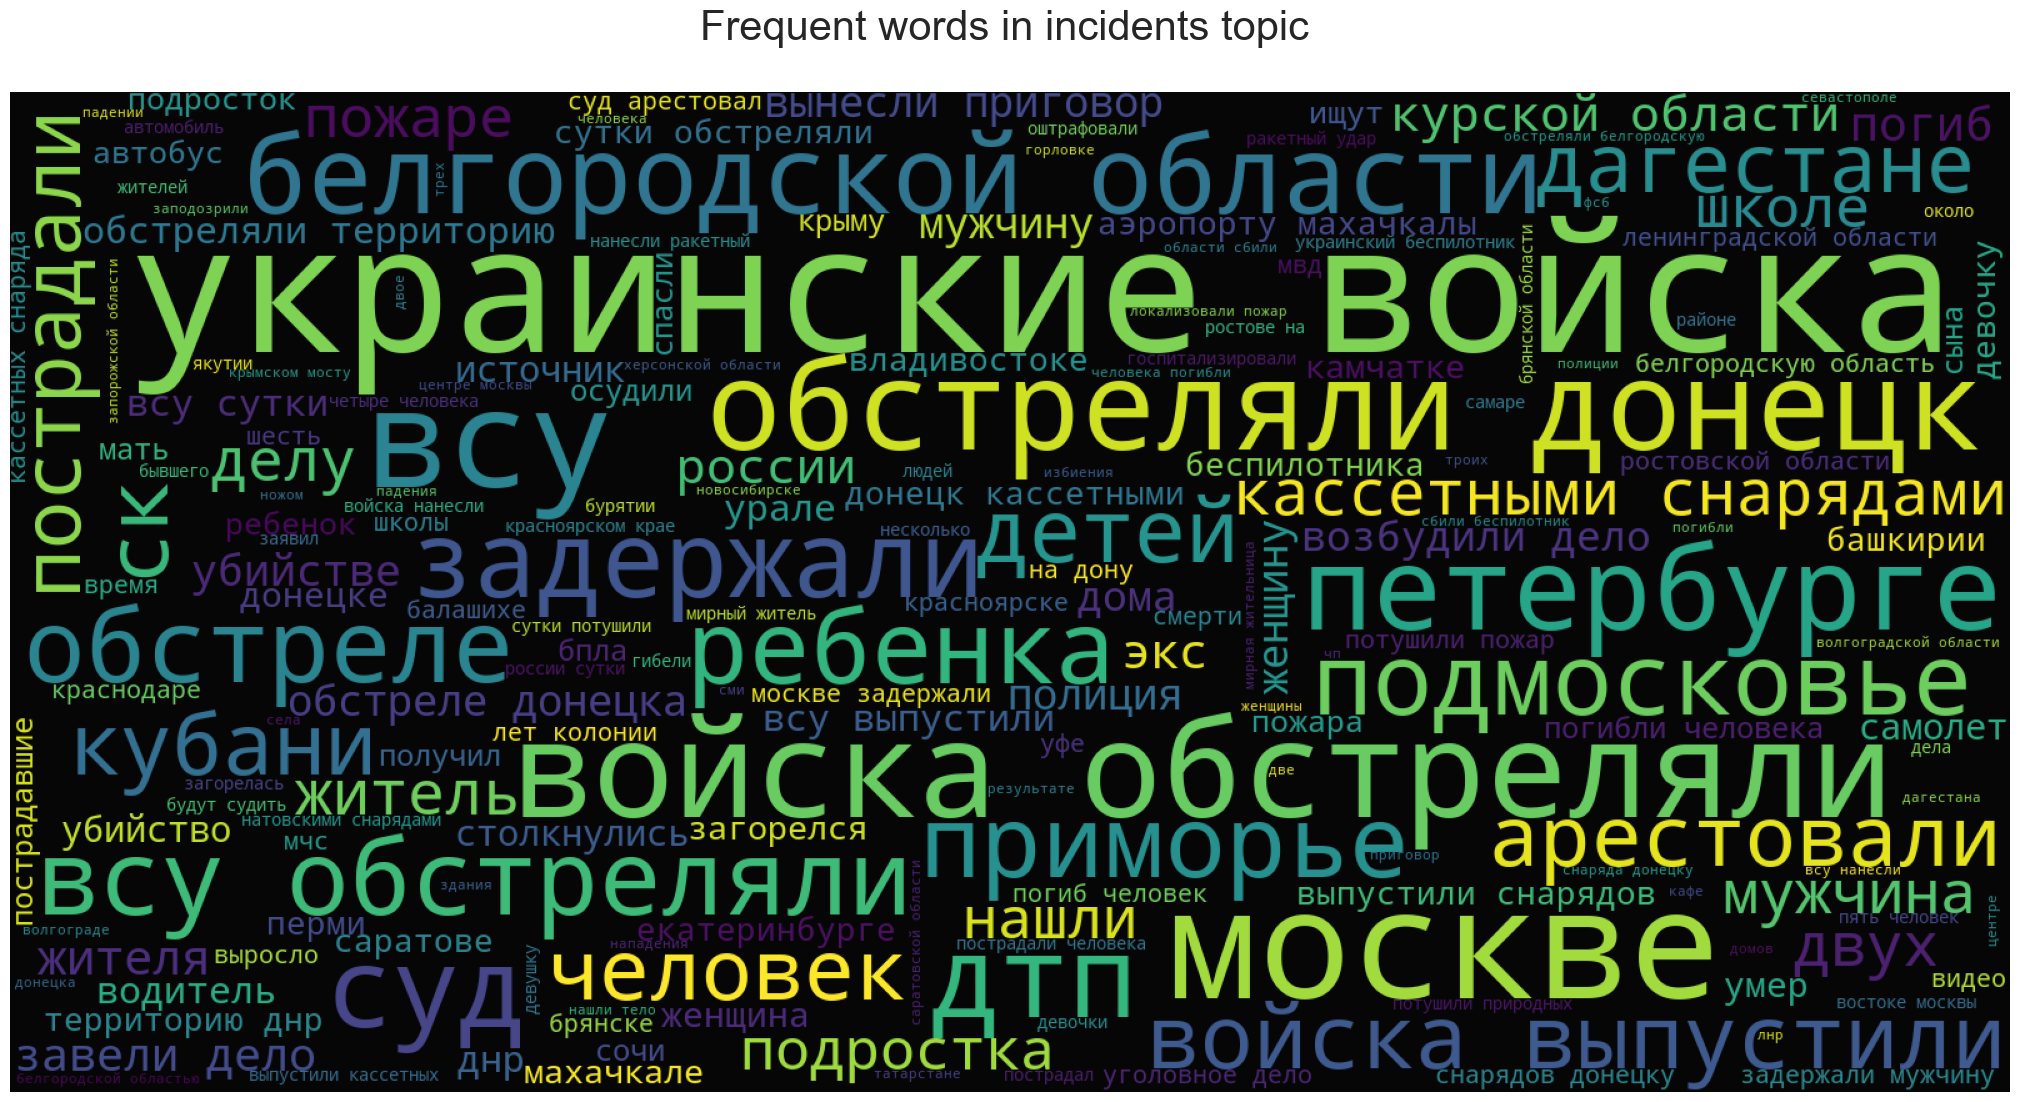

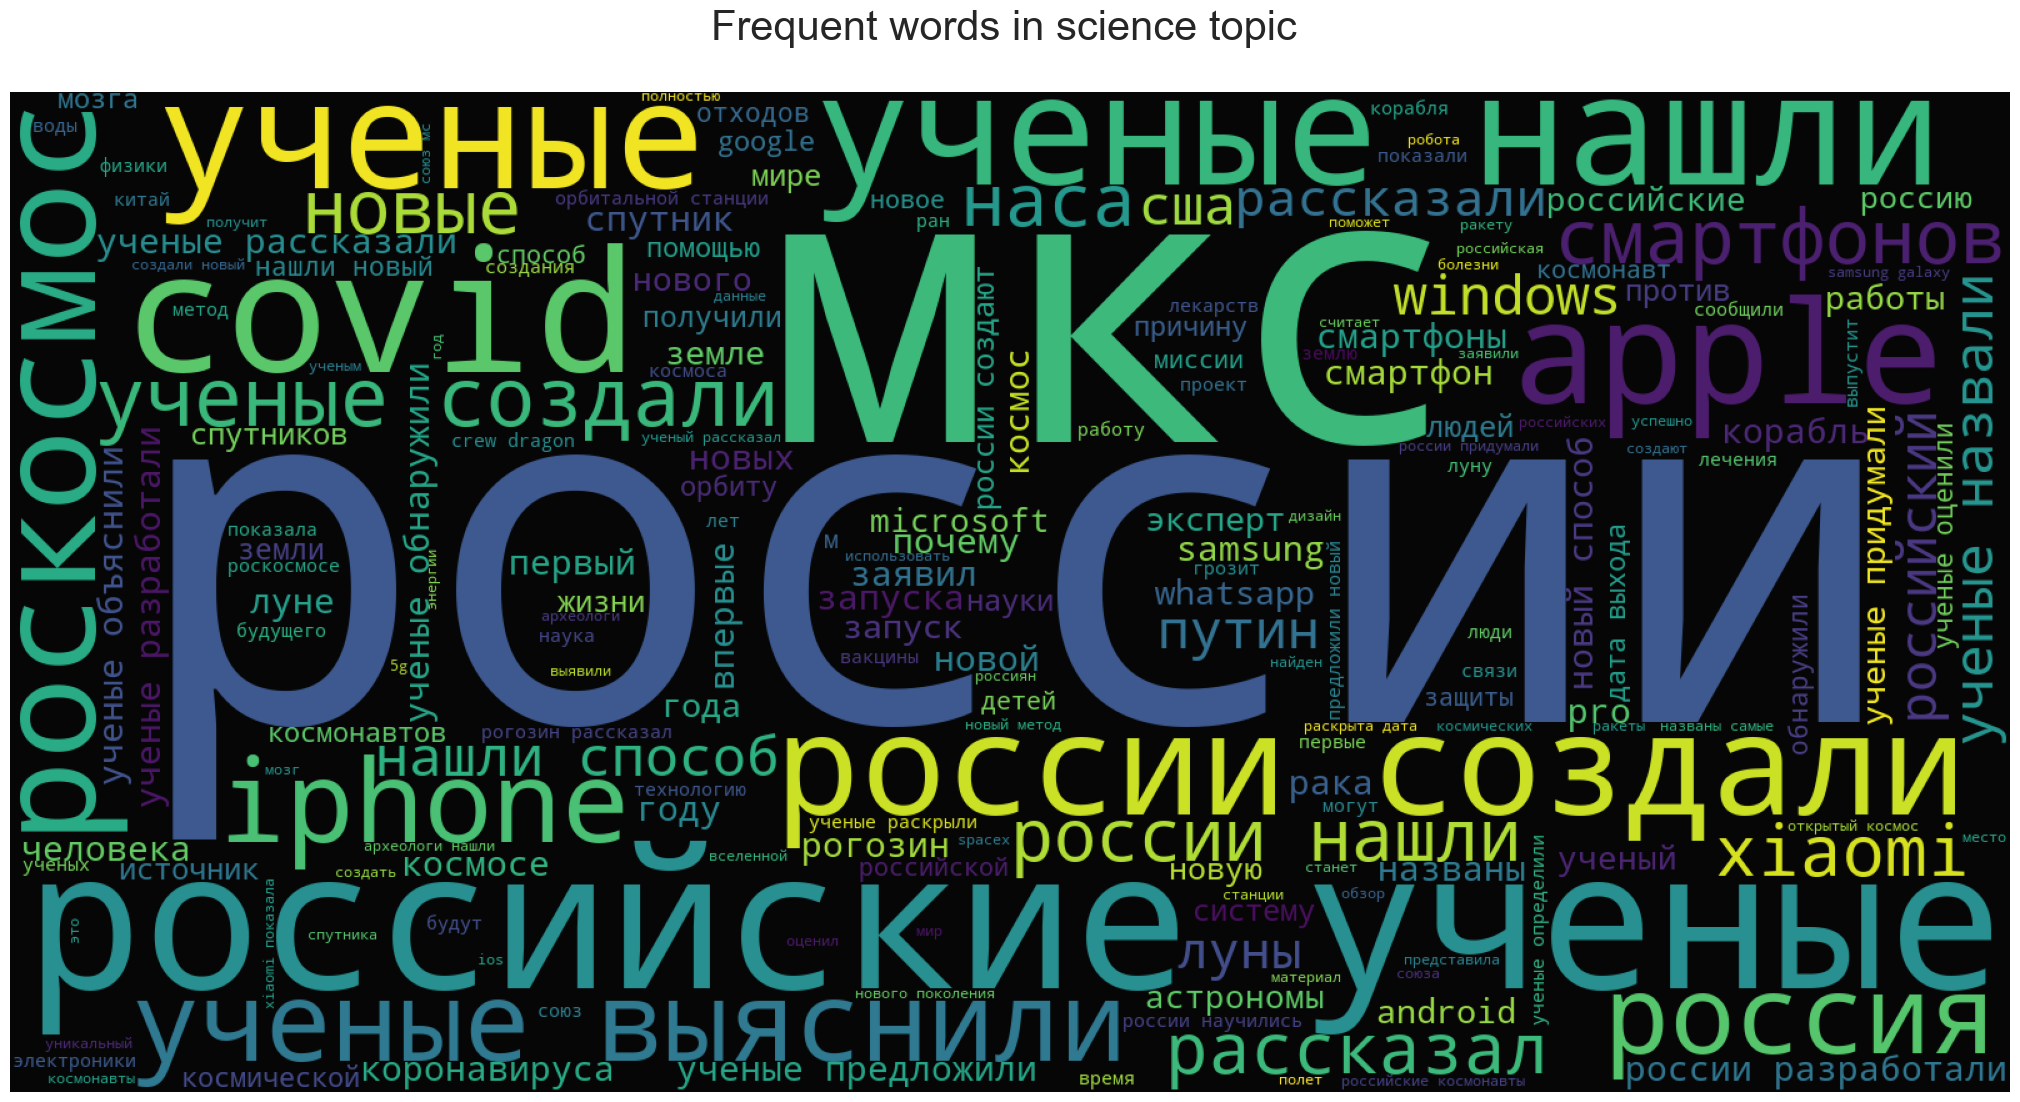

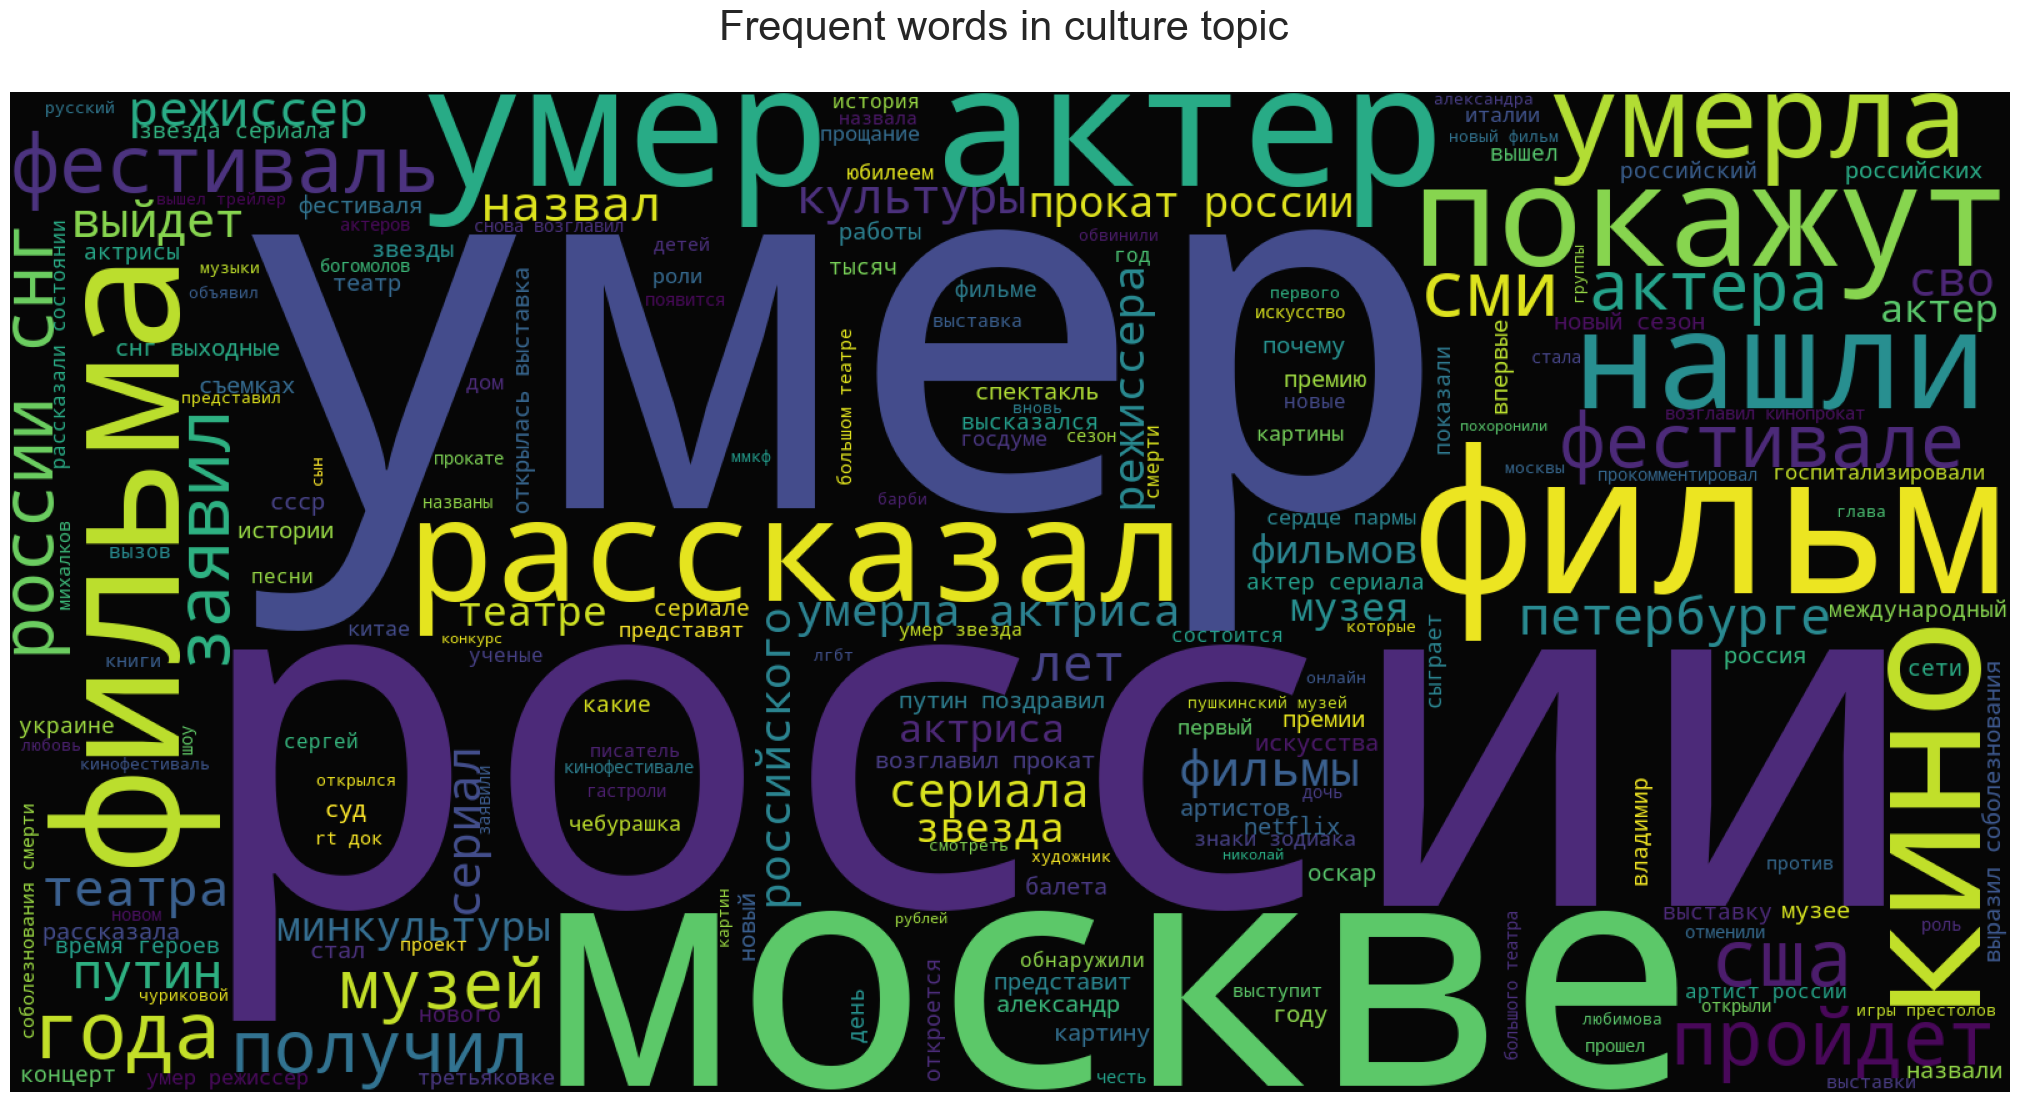

In [51]:
%%time
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(" ").explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic \n", fontsize=30)
    ax.imshow(wc, alpha=0.98)

### Общий вывод

На данном этапе мы провели первичный анализ датасета. 

* В данном датасете представлены статьи по 7 тематикам: science (наука), incidents (происшествия), culture (культура), politics (политика), world (новости в мире), economy (экономика), society (общество). 
Статьи распределены по тематикам почти равномерно: немного проседает тема society and economy.  

* В датасете представлены новостные статьи с 2021 по 2023 год. Большая часть новостей относится к 2023 году. (Выгрузка осуществлялась в обратном хронологическом порядке.) 
По дням недели на текущих данных можно судить больше. Меньше всего новостей выходит в выходные и больше всего в первые три дня рабочей недели - понедельник, вторник, среда. 

* Не у всех статей есть подзаголовок, поэтому в дальнейшем мы его из признаков исключим. В среднем длина заголовка по всем категориям около 65 символов. Длина текста имеет тяжелые хвосты, особенно по категориям 'economy', 'science' и 'culture'. А также эти признаки распределены не нормально. Их следует логарифмировать перед обучением модели.  

* Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

* Размер нелематизированного корпуса: 5 160 912. 

Финальный датафрейм

In [53]:
df = df.drop("subtitle", axis=1)
df.tail()

url  \
23185   https://ria.ru/20220815/tavrida-1808688314.html   
23186  https://ria.ru/20220815/festival-1809577249.html   
23187    https://ria.ru/20220814/rushdi-1809523191.html   
23188       https://ria.ru/20220814/pik-1809507333.html   
23189   https://ria.ru/20220814/rowling-1809479695.html   

                                                   title  \
23185  Проснулся знаменитым: как "Таврида.АРТ" делает...   
23186  Пакистан стал победителем седьмого фестиваля ф...   
23187  Агент писателя Рушди рассказал о его самочувствии   
23188  Умер тесть Тарантино, израильский певец и комп...   
23189  Роулинг заявила в полицию из-за угроз после на...   

                                                 content            datetime  \
23185  Сегодня у молодых талантов много возможностей ... 2022-08-15 08:00:00   
23186  Пакистан стал победителем седьмого фестиваля ф... 2022-08-15 01:17:00   
23187  Британский писатель Салман Рушди, на которого ... 2022-08-14 17:17:00   
23188  Легендарный израильский певец и композитор Цви... 2022-08-14 15:38:00   
23189  Британская писательница, автор серии романов о... 2022-08-14 12:42:00   

         topic  year  month weekday  len_title  len_subtitle  len_content  
23185  culture  2022      8  Monday         71             0         4658  
23186  culture  2022      8  Monday         74            74          545  
23187  culture  2022      8  Sunday         49            88         1257  
23188  culture  2022      8  Sunday         62            82          637  
23189  culture  2022      8  Sunday         62            84         2134